In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import pandas as pd

from matplotlib.pyplot import figure

In [2]:
data = np.genfromtxt("../../datasets/raw/latest.grid", skip_header=6, skip_footer=18)    
rain = np.genfromtxt("../../datasets/raw/rain/2019123120191231.grid", skip_header=6, skip_footer=18)
temp = np.genfromtxt("../../datasets/raw/temp/2019123120191231.grid", skip_header=6, skip_footer=18)

dim_x, dim_y = (1250, 1000)

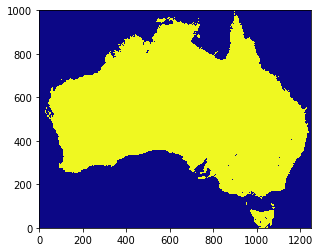

In [3]:
def construct_mask(data, dim_x, dim_y, save=False):
    """
    Constructs a mask image from vegatation data for specified dimensions and optionally save them
    Original ratio: 672, 841 -->  +/- 1:1.25
    """    
    # Scale to a binary image
    data = np.where(data > 1, data, 1)
    data = np.where(data < 2, data, 0)
    data = data.astype(int)
    
    data = np.flip(data, 0)
    data = cv2.resize(data, (dim_x, dim_y), interpolation=cv2.INTER_NEAREST)

    np.save("../../datasets/processed/australia_mask", data) if save is True else False
    return data

plt.imshow(construct_mask(data, dim_x, dim_y), cmap='plasma', interpolation='nearest', origin='lower')
plt.show()

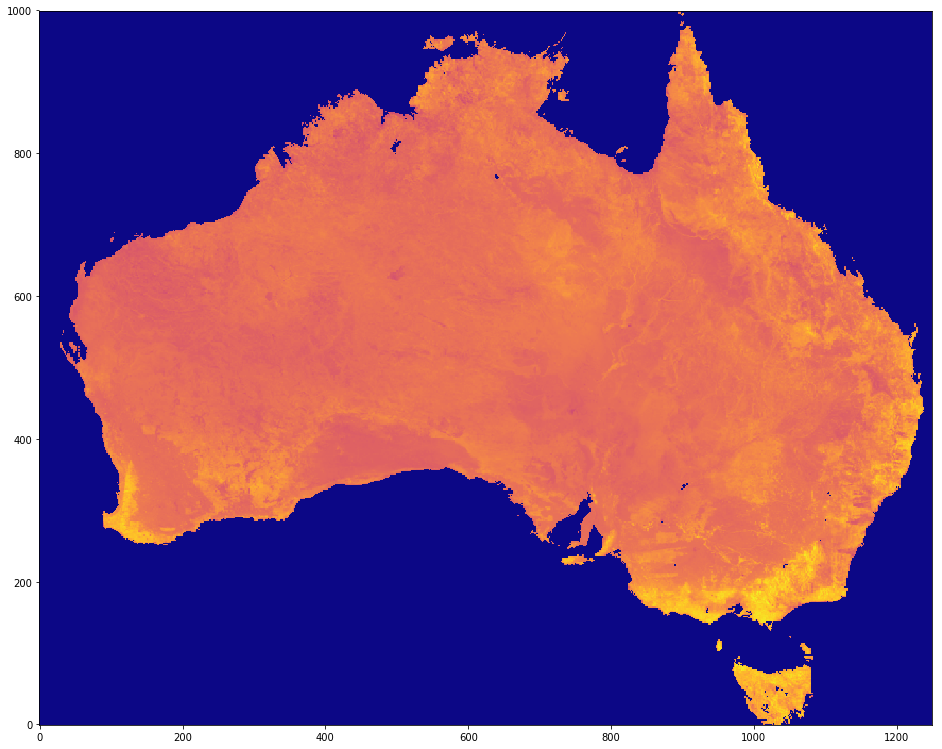

In [17]:
def construct_vegetation(data, dim_x, dim_y, save=False):
    """
    Constructs a vegetation image for specified dimensions and optionally save them
    Normalizes vegatation data to 0.0:1.0
    Sets ocean to -1
    Original ratio: 672, 841 -->  +/- 1:1.25
    """
    # Normalize vegetation
    min_value = np.min(data)
    max_value = np.unique(data)[-2]
    
    data = data - min_value
    data = data / (max_value - min_value)
    
    # Set ocean to -1
    data = np.where(data < 4, data, -1)
    
    data = np.flip(data, 0)
    data = cv2.resize(data, (dim_x, dim_y), interpolation=cv2.INTER_NEAREST)
        
    np.save("../../datasets/processed/australia_vegetation", data) if save is True else False
    return data


figure(figsize=(16, 16))

plt.imshow(construct_vegetation(data, 1250, 1000), cmap='plasma', interpolation='nearest', origin='lower')
plt.show()

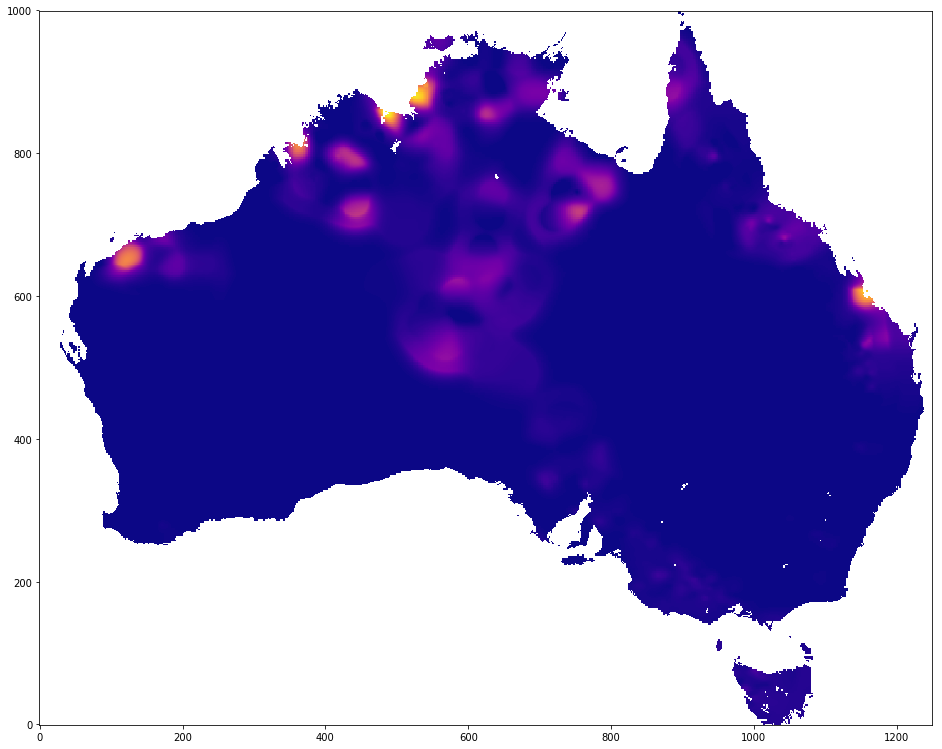

In [5]:
def construct_precipitation(data, dim_x, dim_y, mask=False):
    """
    Constructs a precipitation image for specified dimensions with an optional mask image.
    """
    data = np.flip(data, 0)
    data = cv2.resize(data, (dim_x, dim_y), interpolation=cv2.INTER_NEAREST)
    
    if mask is not False:
        data = np.ma.masked_where(mask == 0, data)
    return data

figure(figsize=(16, 16))
plt.imshow(construct_precipitation(rain, 1250, 1000, construct_mask(data, 1250, 1000)), cmap='plasma', interpolation='nearest', origin='lower')
plt.show()

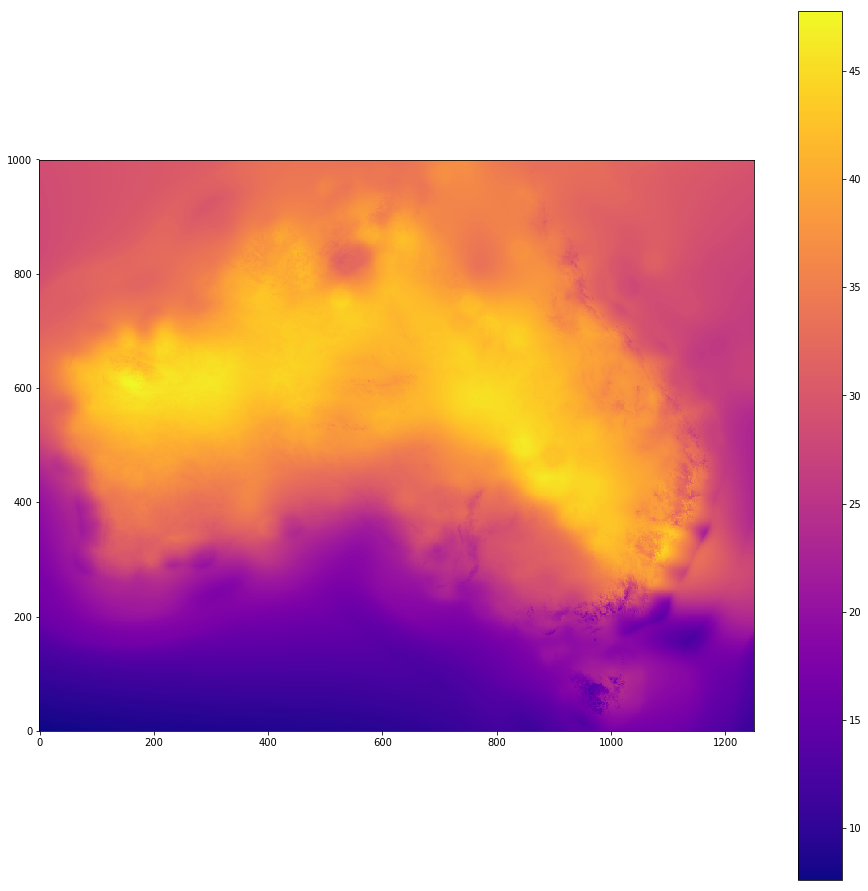

In [24]:
def construct_temperature(data, dim_x, dim_y, round=False):
    """
    """
    data = np.flip(data, 0)
    data = cv2.resize(data, (dim_x, dim_y), interpolation=cv2.INTER_NEAREST)
    
    data = data.astype(int) if round is True else data    
    
    return data


figure(figsize=(16, 16))
plt.imshow(construct_temperature(temp, 1250, 1000), cmap='plasma', interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

In [20]:
raw_data = pd.read_csv("../../datasets/raw/fire_nrt_V1_95405.csv") 

lat = raw_data.latitude
lon = raw_data.longitude

max_lat = max(lat)
min_lat = min(lat)
max_lon = max(lon)
min_lon = min(lon)

def select_timeframe(dataframe, start, end):
    """
    select a start and an end date (int) of the 92 days of available data
    """
    
    assert end - start > 0    
    date_range = dataframe.acq_date.unique()[start : end]
    
    return dataframe.loc[dataframe['acq_date'].isin(date_range)].reset_index()




def normalize_coordinates(input_data, x_scale, y_scale):
    lat = input_data.latitude
    lon = input_data.longitude
    
    # Normalize coordinates
    df = pd.DataFrame()
    df['lat'] = (lat - min_lat) / (max_lat - min_lat)
    df['lon'] = (lon - min_lon) / (max_lon - min_lon)

    df['lon'] = df.lon * (x_scale - 1)
    df['lat'] = df.lat * (y_scale - 1)

    # Round
    df['lon'] = round(df.lon)
    df['lat'] = round(df.lat)
    return df

def construct_heatmap(df, in_x, in_y, out_x, out_y, scale_on=True):
    im = np.zeros((in_y, in_x))
    heat_range = len(df)
    
    for i in range(heat_range):
        if im[int(df.lat[i]), int(df.lon[i])] == 0:
            im[int(df.lat[i]), int(df.lon[i])] = 2

        else:
            if scale_on is True:
                im[int(df.lat[i]), int(df.lon[i])] += 0
    
    im = cv2.resize(im, (out_x, out_y), interpolation=cv2.INTER_NEAREST)
    return im

timeframe_firemap = select_timeframe(raw_data, 0, 92)
normalized_firemap = normalize_coordinates(timeframe_firemap, 1250, 1000)
heatmap = construct_heatmap(normalized_firemap, 1250, 1000, 1250, 1000, scale_on=True)

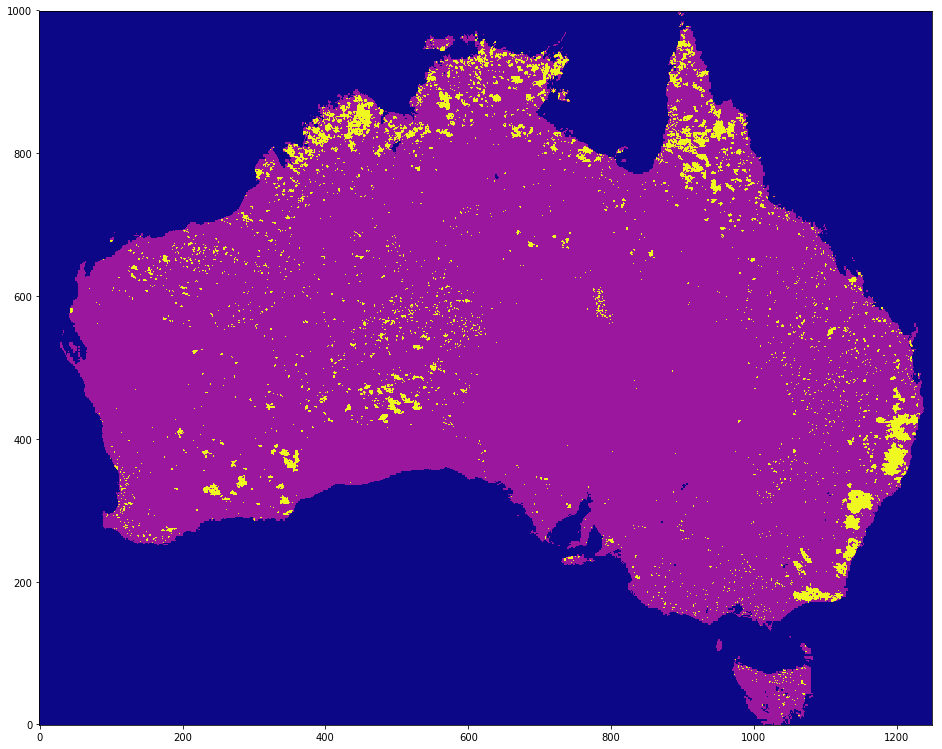

In [21]:
def scale_firemap(firemap, dim_x, dim_y):  
    shape = np.shape(firemap)
    
    # left 
    firemap = np.concatenate((np.zeros((dim_y, 45)), firemap), 1)
    # right
    firemap = np.concatenate((firemap, np.zeros((dim_y, 18))), 1)
    # top
    firemap = firemap[:-17]
    # bottom 
    shape = np.shape(firemap)
    firemap = np.concatenate((np.zeros((10, shape[1])), firemap), 0)    
    return cv2.resize(firemap, (dim_x, dim_y), interpolation=cv2.INTER_NEAREST) + construct_mask(data, 1250, 1000)

heatmap2 = scale_firemap(heatmap, 1250, 1000)

figure(figsize=(16, 16))
plt.imshow(heatmap2, cmap='plasma', interpolation='nearest', origin='lower')
plt.show()

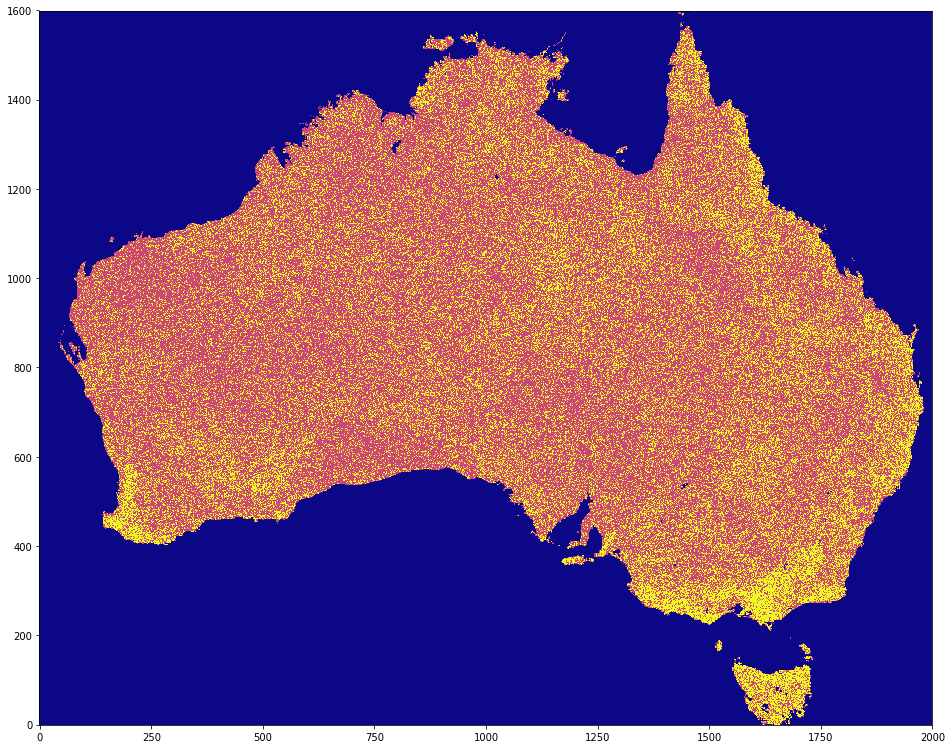

In [28]:
def construct_density_map(data, dim_x, dim_y, margin=0, save=False):
    """
    Construct a trinary image with a vegetation density scaled to the actual vegetation in Australia
    0 = water
    1 = land (not flameble)
    2 = vegatation (flameble)
    """
    data = construct_vegetation(data, dim_x, dim_y)
    density_map = np.ones((dim_y, dim_x))
    
    for row in range(dim_y):
        for col in range(dim_x):
            res = data[row, col]
            
            if res == -1:
                density_map[row, col] = 0
                
            else:
                if res < random.random():
                    density_map[row, col] = 1
                else:
                    density_map[row, col] = 2
                    
    np.save("../../datasets/processed/australia_vegetation", data) if save is True else False                 
                    
    return density_map

figure(figsize=(16, 16))
plt.imshow(construct_density_map(data, 2000, 1600, save=True), cmap='plasma', interpolation='nearest', origin='lower')
plt.show()

In [11]:
def test_functions():
    data = np.genfromtxt("../../datasets/raw/testgrid.grid", skip_header=6, skip_footer=18)
    mask = np.genfromtxt("../../datasets/raw/latest.grid", skip_header=6, skip_footer=18)

    test1 = construct_mask(data, 200, 200)
    assert np.shape(test1) == (200, 200), '%s %s != (200, 200)' % (np.shape(test1)[0], np.shape(test1)[1])
    assert len(np.unique(test1)) == 2, 'output is not a binary image'
    print('construct_mask: passed')   
    
    test2 = construct_vegetation(data, 200, 200)
    assert np.shape(test2) == (200, 200), '(%s, %s) != (200, 200)' % (np.shape(test2)[0], np.shape(test2)[1])
    assert np.min(test2) >= -1 and np.max(test2) <= 1, 'data should be in range 0.0:1.0'
    print('construct_vegetation: passed')    
    
    test3 = construct_precipitation(data, 200, 200)
    assert np.shape(test3) == (200, 200), '(%s, %s) != (200, 200)' % (np.shape(test3)[0], np.shape(test3)[1])
    test4 = construct_precipitation(data, 200, 200, construct_mask(mask, 200, 200))
    assert np.shape(test4) == (200, 200), '(%s, %s) != (200, 200)' % (np.shape(test4)[0], np.shape(test4)[1])
    print('construct_precipitation: passed')  
    
    test5 = construct_density_map(data, 200, 200)
    assert np.shape(test5) == (200, 200), '(%s, %s) != (200, 200)' % (np.shape(test5)[0], np.shape(test5)[1])

    print('construct_density_map: passed')  


    return 

test_functions()

construct_mask: passed
construct_vegetation: passed
construct_precipitation: passed
construct_density_map: passed
